# Analysis on secure logs

In [1]:
import os
import sys
import numpy as np
import pandas as pd

In [2]:
sys.path.append('../')
sys.path.append('../src/')
sys.path.append('../spell/')

In [3]:
import Reader
import ParamsExtractor2
import DataPreprocessor
import ReduceDim
import ClusterData
import DetectAnomaly

2024-06-26 14:36:55.213035: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 14:36:55.213654: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 14:36:55.218805: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 14:36:55.271185: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 14:36:56.078773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## Training

In [4]:
log_types = ['secure']
dates = ['20240418', '20240420', '20240429']
login_node_numbers = ['01', '02', '03', '10']

# Generate the list of file paths
file_paths = [f'/../../../temp_logs/{date}/login{num}.{logtype}.log' for date in dates for num in login_node_numbers for logtype in log_types]

# Filter the list to include only existing files
existing_file_paths = [path for path in file_paths if os.path.exists(path)]
print(existing_file_paths)

df_list = []

for file_path in existing_file_paths:
    r = Reader.Reader(file_path)
    df = r.read_file(file_path)
    df_list.append(df)

['/../../../temp_logs/20240418/login01.secure.log', '/../../../temp_logs/20240418/login02.secure.log', '/../../../temp_logs/20240418/login03.secure.log', '/../../../temp_logs/20240418/login10.secure.log', '/../../../temp_logs/20240420/login01.secure.log', '/../../../temp_logs/20240420/login02.secure.log', '/../../../temp_logs/20240420/login03.secure.log', '/../../../temp_logs/20240420/login10.secure.log']


In [5]:
len(df_list)

8

In [6]:
df_after = []

for i, df in enumerate(df_list):
    p = ParamsExtractor2.ParamsExtractor(df)
    df = p.convert_params(df)
    new_df = p.get_params()
    df_after.append(new_df)
    df_list[i] = pd.concat([df_list[i], new_df], axis=1)

In [7]:
df_list[0].head()

,host,ident,pid,message,severity,facility,time,severity_numbers,facility_numbers,severity_scores,timedelta,ip,port,session,log key,log key spell
0,login01,systemd,37690,pam_unix(systemd-user:session): session opened...,info,authpriv,2024-04-18 00:00:01 +0200,6,10,1.0,0.0,-1,-1,opened,96,-1
1,login01,sshd,37759,Accepted publickey for root from 10.44.0.12 po...,info,authpriv,2024-04-18 00:00:02 +0200,6,10,1.0,1.0,10.44.0.12,44266,-1,97,52
2,login01,sshd,37759,pam_unix(sshd:session): session opened for use...,info,authpriv,2024-04-18 00:00:02 +0200,6,10,1.0,0.0,-1,-1,opened,96,-1
3,login01,sshd,37765,Received disconnect from 10.44.0.12 port 44266...,info,authpriv,2024-04-18 00:00:02 +0200,6,10,1.0,0.0,10.44.0.12,44266,-1,98,-1
4,login01,sshd,37765,Disconnected from user root 10.44.0.12 port 44266,info,authpriv,2024-04-18 00:00:02 +0200,6,10,1.0,0.0,10.44.0.12,44266,-1,99,55


In [8]:
for i, df in enumerate(df_list):
    d = DataPreprocessor.DataPreprocessor(df)
    enc = d.drop_and_hash_encode()
    df_list[i] = enc

print(df_list[0].head())

   severity_scores  timedelta   port  log key  log key spell  col_0  col_1  \
0              1.0        0.0     -1       96             -1      0      0   
1              1.0        1.0  44266       97             52      1      0   
2              1.0        0.0     -1       96             -1      1      0   
3              1.0        0.0  44266       98             -1      1      0   
4              1.0        0.0  44266       99             55      1      0   

   col_2  col_3  col_4  ...  col_10  col_11  col_12  col_13  col_14  col_15  \
0      0      0      0  ...       0       0       3       0       0       0   
1      0      0      0  ...       0       1       1       0       0       0   
2      0      0      0  ...       0       1       2       0       0       0   
3      0      0      0  ...       0       0       1       0       0       0   
4      0      0      0  ...       0       0       1       0       0       0   

   col_16  col_17  col_18  col_19  
0       1       0   

In [9]:
for df in df_list:
    print(df.shape)

(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)


In [10]:
normal_dataset = df_list[0]

for i in range(1,len(df_list)):
    normal_dataset = np.vstack([normal_dataset, df_list[i]])

In [11]:
normal_dataset.shape

(8000, 25)

## Anomalies' dataset

In [12]:
log_types = ['secure']

# Generate the list of file paths
file_paths = [f'../data/linpeas_logs_1/{logtype}_logs.log' for logtype in log_types]

# Filter the list to include only existing files
existing_file_paths = [path for path in file_paths if os.path.exists(path)]

an_df_list = []

for file_path in existing_file_paths:
    r = Reader.Reader(file_path)
    df = r.read_file_2(file_path)
    an_df_list.append(df)

In [13]:
an_df_list[0].head()

,host,ident,pid,message,severity,facility,time
0,localhost,sudo[3680]:,3680,matteo : TTY=pts/0 ; PWD=/home/matteo ; USER...,notice,authpriv,2024-06-22T11:55:39.520333-04:00
1,localhost,sudo[3680]:,3680,pam_unix(sudo:session): session opened for use...,info,authpriv,2024-06-22T11:55:39.526046-04:00
2,localhost,sudo[3680]:,3680,pam_unix(sudo:session): session closed for use...,info,authpriv,2024-06-22T11:55:39.974240-04:00
3,localhost,sudo[3693]:,3693,matteo : TTY=pts/0 ; PWD=/home/matteo ; USER...,notice,authpriv,2024-06-22T11:55:46.643379-04:00
4,localhost,sudo[3693]:,3693,pam_unix(sudo:session): session opened for use...,info,authpriv,2024-06-22T11:55:46.655326-04:00


In [14]:
an_df_after = []

for i, df in enumerate(an_df_list):
    p = ParamsExtractor2.ParamsExtractor(df)
    df = p.convert_params(df)
    new_df = p.get_params()
    an_df_after.append(new_df)
    an_df_list[i] = pd.concat([an_df_list[i], new_df], axis=1)

In [15]:
an_df_list[0].head()

,host,ident,pid,message,severity,facility,time,severity_numbers,facility_numbers,severity_scores,timedelta,ip,port,session,log key,log key spell
0,localhost,sudo[3680]:,3680,matteo : TTY=pts/0 ; PWD=/home/matteo ; USER...,notice,authpriv,2024-06-22T11:55:39.520333-04:00,5,10,2.718282,0.000000,-1,-1,-1,414,-1
1,localhost,sudo[3680]:,3680,pam_unix(sudo:session): session opened for use...,info,authpriv,2024-06-22T11:55:39.526046-04:00,6,10,1.000000,0.005713,-1,-1,opened,415,-1
2,localhost,sudo[3680]:,3680,pam_unix(sudo:session): session closed for use...,info,authpriv,2024-06-22T11:55:39.974240-04:00,6,10,1.000000,0.448194,-1,-1,closed,100,53
3,localhost,sudo[3693]:,3693,matteo : TTY=pts/0 ; PWD=/home/matteo ; USER...,notice,authpriv,2024-06-22T11:55:46.643379-04:00,5,10,2.718282,6.669139,-1,-1,-1,416,56
4,localhost,sudo[3693]:,3693,pam_unix(sudo:session): session opened for use...,info,authpriv,2024-06-22T11:55:46.655326-04:00,6,10,1.000000,0.011947,-1,-1,opened,415,-1


In [16]:
for i, df in enumerate(an_df_list):
    d = DataPreprocessor.DataPreprocessor(df)
    enc = d.drop_and_hash_encode()
    an_df_list[i] = enc

print(an_df_list[0].head())

   severity_scores  timedelta port  log key  log key spell  col_0  col_1  \
0         2.718282   0.000000   -1      414             -1      1      1   
1         1.000000   0.005713   -1      415             -1      1      1   
2         1.000000   0.448194   -1      100             53      2      1   
3         2.718282   6.669139   -1      416             56      0      0   
4         1.000000   0.011947   -1      415             -1      0      0   

   col_2  col_3  col_4  ...  col_10  col_11  col_12  col_13  col_14  col_15  \
0      0      0      0  ...       0       0       2       0       0       0   
1      0      0      0  ...       0       0       2       0       0       0   
2      0      0      0  ...       0       0       1       0       0       0   
3      0      0      0  ...       0       0       2       0       0       2   
4      0      0      0  ...       0       0       2       0       0       2   

   col_16  col_17  col_18  col_19  
0       0       0       0       

In [17]:
# we test secure
# we take the lines from the 230th (detected pwd bruteforcing)
anomalous_dataset = an_df_list[0][230:]

In [18]:
anomalous_dataset.shape

(770, 25)

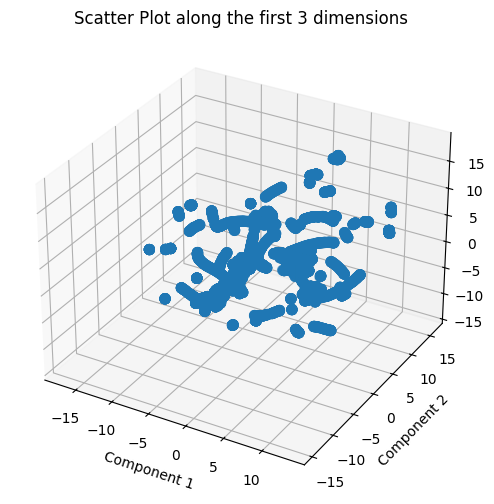

In [19]:
r = ReduceDim.ReduceDim(3, normal_dataset, [1,0])
umap_reduced_data = r.umap()

In [20]:
anomalous_points = r.test_umap(anomalous_dataset)
new_data = np.vstack([umap_reduced_data, anomalous_points])
print(new_data)

[[ -6.8324547  14.770981   -2.4211588]
 [-10.582571    3.210052    2.6875463]
 [  1.5035594  11.360007  -10.594377 ]
 ...
 [ 12.383155    9.35957    11.123082 ]
 [  1.7375495  11.566889  -10.132403 ]
 [ -2.746352   12.484652   -6.265132 ]]


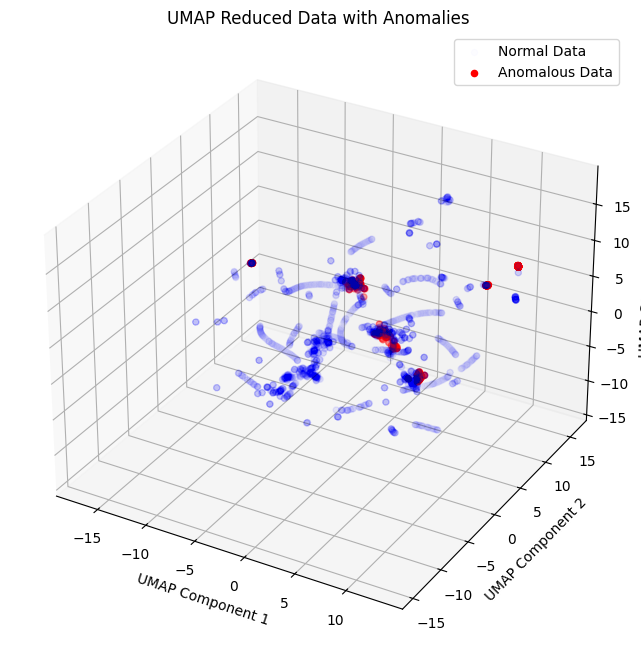

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming umap_reduced_data and anomalous_points have 3 components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot normal data in blue
ax.scatter(umap_reduced_data[:, 0], umap_reduced_data[:, 1], umap_reduced_data[:, 2], color='blue', alpha=0.01, label='Normal Data')

# Plot anomalous data in red
ax.scatter(anomalous_points[:, 0], anomalous_points[:, 1], anomalous_points[:, 2], color='red', label='Anomalous Data')

ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
ax.set_title('UMAP Reduced Data with Anomalies')
ax.legend()

plt.show()


Same conclusions as notebook 5. Maybe with different types of decompositions it works better

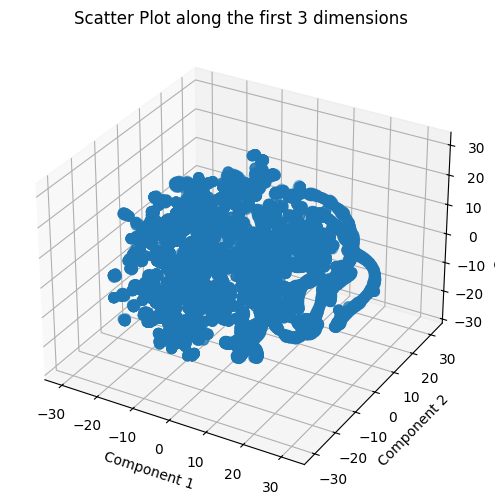

[[-10.684838  -11.790697   15.803817 ]
 [  5.2331533  13.555648   15.7636795]
 [ -8.806722  -18.843212    2.7496786]
 ...
 [-17.201149   16.51476    -9.979636 ]
 [-15.596471   21.211184   -8.011067 ]
 [-10.748941   13.979268    6.980487 ]]


In [22]:
r = ReduceDim.ReduceDim(3, normal_dataset, [1,0])
tsne_reduced_data = r.tsne()

anomalous_points = r.test_tsne(anomalous_dataset)
new_data = np.vstack([tsne_reduced_data, anomalous_points])
print(new_data)

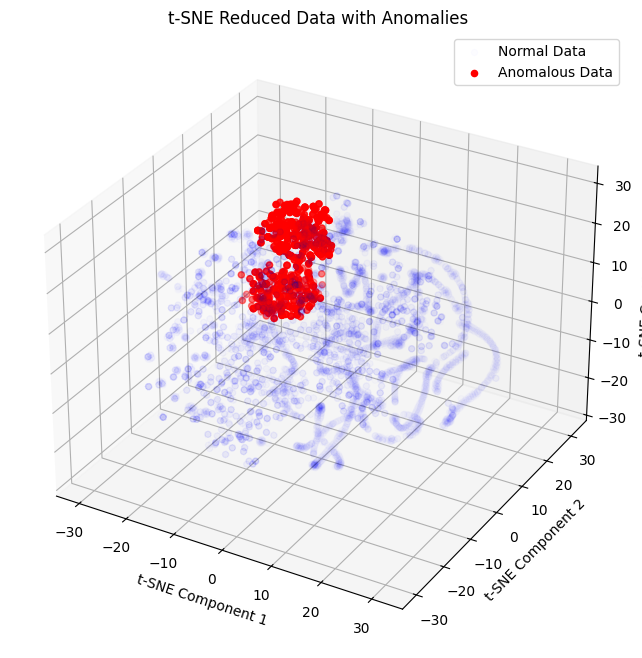

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming umap_reduced_data and anomalous_points have 3 components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot normal data in blue
ax.scatter(tsne_reduced_data[:, 0], tsne_reduced_data[:, 1], tsne_reduced_data[:, 2], color='blue', alpha=0.01, label='Normal Data')

# Plot anomalous data in red
ax.scatter(anomalous_points[:, 0], anomalous_points[:, 1], anomalous_points[:, 2], color='red', label='Anomalous Data')

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('t-SNE Reduced Data with Anomalies')
ax.legend()

plt.show()


## Deep Learning

Time independent autoencoder

In [25]:
anomalous_dataset.columns

Index(['severity_scores', 'timedelta', 'port', 'log key', 'log key spell',
       'col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14',
       'col_15', 'col_16', 'col_17', 'col_18', 'col_19'],
      dtype='object')

In [26]:
normal_dataset.shape

(8000, 25)

In [27]:
anomalous_dataset.shape

(770, 25)

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
normal_data = scaler.fit_transform(normal_dataset)
anomalous_data = scaler.transform(anomalous_dataset)

# Define the autoencoder model
input_dim = normal_data.shape[1]
encoding_dim = 3  # You can adjust the encoding dimension as needed

input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder_layer1 = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
decoder_layer1 = tf.keras.layers.Dense(input_dim, activation='sigmoid')(encoder_layer1)
autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoder_layer1)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(normal_data, normal_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1994 - val_loss: 0.1409
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1074 - val_loss: 0.0557
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0474 - val_loss: 0.0419
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0373 - val_loss: 0.0365
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0330 - val_loss: 0.0328
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0297 - val_loss: 0.0306
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0275 - val_loss: 0.0291
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0261 - val_loss: 0.0280
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0251 - val_loss: 0.0270
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0246 - val_loss: 0.0263
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0236 - val_loss: 0.0258
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [29]:
# Use the autoencoder to reconstruct the normal and anomalous data
normal_reconstruction = autoencoder.predict(normal_data)
anomalous_reconstruction = autoencoder.predict(anomalous_data)

# Calculate the reconstruction error
normal_reconstruction_error = np.mean(np.square(normal_data - normal_reconstruction), axis=1)
anomalous_reconstruction_error = np.mean(np.square(anomalous_data - anomalous_reconstruction), axis=1)

print(f"Mean normal reconstruction error: {np.mean(normal_reconstruction_error)}")
print(f"Mean anomalous reconstruction error: {np.mean(anomalous_reconstruction_error)}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean normal reconstruction error: 0.020599124623308734
Mean anomalous reconstruction error: 0.08968683608104067


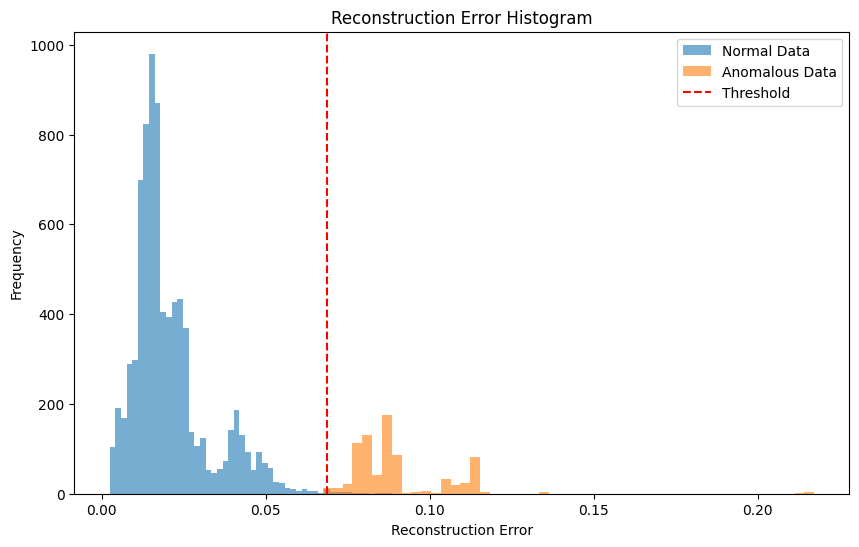

Threshold for anomaly detection: 0.06864924209058788
Number of anomalies detected: 769


In [30]:
# Determine a threshold for anomaly detection (e.g., based on the 95th percentile of the reconstruction error)
threshold = np.percentile(normal_reconstruction_error, 99.75)

# Identify anomalies
anomalies = anomalous_reconstruction_error > threshold

# Plot the reconstruction error
plt.figure(figsize=(10, 6))
plt.hist(normal_reconstruction_error, bins=50, alpha=0.6, label='Normal Data')
plt.hist(anomalous_reconstruction_error, bins=50, alpha=0.6, label='Anomalous Data')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Reconstruction Error Histogram')
plt.show()

# Print the results
print("Threshold for anomaly detection:", threshold)
print("Number of anomalies detected:", np.sum(anomalies))

We can see that in the case of logs that record password bruteforcing we can succesfully tell them apart from normal ones.